In [714]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt


## 1. Constructing Event-Time Panel Data

In [715]:

# Load data
data = pd.read_csv("final_df.csv")

# Convert 'Date' and 'event_date' to datetime
data["Date"] = pd.to_datetime(data["Date"])
data["event_date"] = pd.to_datetime(data["event_date"])

# # Filter out rows where 'event_id' is NaN
data = data.dropna(subset=["event_id"])

# events_in = [        
#     "2023_mineral_export_restrictions",  
#     "2023_aug_investment_ban",          
#     "2024_march_export_tightening",   
#     "2024_tariff_increase_ev_battery", 
#     "2024_tariff_finalization",    
#     "2024_nvidia_antitrust_probe"    
# ]



# data = data[data["event_id"].isin(events_in)]


# Remove the day before the event (k = -1) as the base period
df_reg = data[data["event_time"] != -1]  # The last time point “not affected by policy”

# Remove 'QQQ' as a control group (we want only firm-level analysis)

df_reg = df_reg[df_reg['ticker'] != 'QQQ']


# Make sure 'event_time' is a categorical variable
df_reg['event_time'] = df_reg['event_time'].astype(float).astype(int).astype('category')


# Select the relevant columns for Event-time DiD analysis
df_reg = df_reg[
    ["ticker", "event_id", "event_time", "Treatment", "abnormal_return"]
]

# # test
# print(df_reg["Treatment"].value_counts())
# print(df_reg["event_time"].value_counts())

# print(df_reg.isnull().sum())  # should all be 0
# print(df_reg.duplicated().sum())  # should no replicate

In [716]:
df_reg.info()
print(sorted(df_reg['ticker'].unique()))


<class 'pandas.core.frame.DataFrame'>
Index: 1408 entries, 440 to 16386
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   ticker           1408 non-null   object  
 1   event_id         1408 non-null   object  
 2   event_time       1408 non-null   category
 3   Treatment        1408 non-null   int64   
 4   abnormal_return  1408 non-null   float64 
dtypes: category(1), float64(1), int64(1), object(2)
memory usage: 57.0+ KB
['ADBE', 'AMD', 'AVGO', 'CRM', 'CRWD', 'CSCO', 'INTC', 'INTU', 'MDB', 'MRVL', 'MU', 'NOW', 'NVDA', 'ORCL', 'QCOM', 'TSM']


## 2. Regression Model

Your model is:

$$
\text{abnormal\_return}_{it} = \alpha + \sum_{k \neq -1} \theta_k \cdot \mathbf{1}\{\text{event\_time} = k\} + \sum_{k \neq -1} \beta_k \cdot \mathbf{1}\{\text{event\_time} = k\} \times \text{Treatment}_i + \gamma_i + \delta_e + \epsilon_{it}
$$

Where:

- $\text{abnormal\_return}_{it}$ = abnormal return for firm $i$ at event time $t$  
- $\mathbf{1}\{\text{event\_time} = k\}$ = dummy for event time $k$ (baseline $k = -1$ omitted)  
- $\text{Treatment}_i$ = 1 if firm $i$ is hardware-dependent, 0 otherwise  
- $\gamma_i$ = firm fixed effects (ticker)  
- $\delta_e$ = event fixed effects (event_id)  
- $\epsilon_{it}$ = error term


In [717]:
model = smf.ols(
    formula="abnormal_return ~ C(event_time) * Treatment + C(ticker) + C(event_id)",
    #abnormal_return ~ C(event_time) * Treatment + C(ticker) 
    data=df_reg
).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_reg['ticker']}  # cluster by firm 
)

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        abnormal_return   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     7.003
Date:                Sun, 27 Apr 2025   Prob (F-statistic):           0.000262
Time:                        22:42:15   Log-Likelihood:                 3137.5
No. Observations:                1408   AIC:                            -6175.
Df Residuals:                    1358   BIC:                            -5913.
Df Model:                          49                                         
Covariance Type:              cluster                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 50, but rank is 15
  warnings.warn('covariance of constraints does not have full '


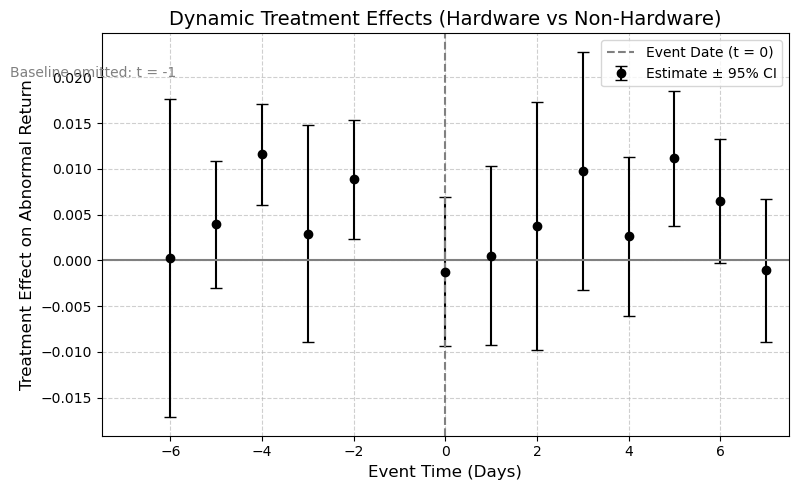

In [718]:
coef = model.params
conf = model.conf_int()

treat_effect = coef[coef.index.str.contains(r'C\(event_time\)\[T\.-?\d+\]:Treatment')].reset_index()
treat_effect.columns = ['term', 'coef']

# Merge confidence intervals
conf_treat = conf.loc[treat_effect['term']]
treat_effect['lower'] = conf_treat[0].values
treat_effect['upper'] = conf_treat[1].values

# Extract integer event_time
treat_effect['event_time'] = treat_effect['term'].str.extract(r'\[T\.?(-?\d+)\]')[0].astype(int)

# Filter ±7 window
treat_effect = treat_effect[treat_effect['event_time'].between(-7, 7)]
treat_effect = treat_effect.sort_values('event_time')

# ========== 4. Plot dynamic treatment effects ==========
plt.figure(figsize=(8, 5))
plt.errorbar(
    treat_effect['event_time'],
    treat_effect['coef'],
    yerr=[
        treat_effect['coef'] - treat_effect['lower'],
        treat_effect['upper'] - treat_effect['coef']
    ],
    fmt='o', capsize=4, color='black', label='Estimate ± 95% CI'
)

plt.axhline(0, color='gray', linestyle='-')
plt.axvline(0, color='gray', linestyle='--', label='Event Date (t = 0)')
plt.xlim(-7.5, 7.5)
plt.title('Dynamic Treatment Effects (Hardware vs Non-Hardware)', fontsize=14)
plt.xlabel('Event Time (Days)', fontsize=12)
plt.ylabel('Treatment Effect on Abnormal Return', fontsize=12)
plt.legend()
plt.text(-9.5, 0.02, 'Baseline omitted: t = -1', fontsize=10, color='gray')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


We estimate an event-time Difference-in-Differences model to evaluate the impact of trade policy announcements on the abnormal returns of hardware-dependent versus software-dependent AI firms.

Pre-treatment period (event times -6 to -2) shows largely statistically insignificant treatment effects, supporting the parallel trends assumption.

Immediately after the event (event time 0 to +4), treatment effects remain statistically insignificant, suggesting no abrupt divergence between the groups following announcements.

However, starting from event time +5, hardware firms begin to experience a positive abnormal return, with the effect becoming statistically significant at the 1% level at event time +5 and marginally significant at event time +6.

The model controls for firm fixed effects and event fixed effects, with standard errors clustered at the firm level to account for within-firm correlations.

Overall, while there is no immediate differential impact, hardware-dependent firms appear to gain a mild advantage a few days after policy events, indicating a delayed market reaction.


## Split the time

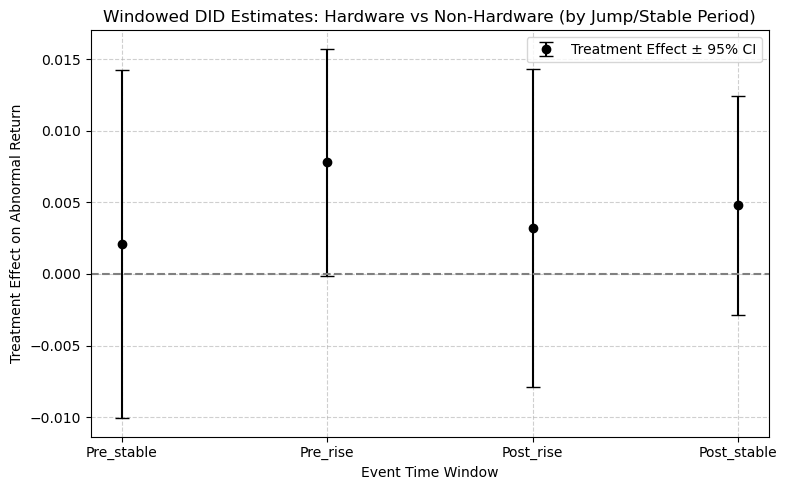

In [719]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ['term', 'coef', 'lower', 'upper', 'event_time']

def assign_window(t):
    if t in [-6, -5]:
        return 'Pre_stable'
    elif t in [-4, -3, -2, -1]:
        return 'Pre_rise'
    elif t in [0, 1, 2, 3]:
        return 'Post_rise'
    elif t in [4, 5, 6, 7]:
        return 'Post_stable'
    else:
        return None

treat_effect['window'] = treat_effect['event_time'].apply(assign_window)
treat_effect = treat_effect.dropna(subset=['window'])

window_summary = treat_effect.groupby('window').agg(
    mean_coef=('coef', 'mean'),
    mean_lower=('lower', 'mean'),
    mean_upper=('upper', 'mean')
).reset_index()

window_summary['yerr_lower'] = window_summary['mean_coef'] - window_summary['mean_lower']
window_summary['yerr_upper'] = window_summary['mean_upper'] - window_summary['mean_coef']

desired_order = ['Pre_stable', 'Pre_rise', 'Post_rise', 'Post_stable']
window_summary['window'] = pd.Categorical(window_summary['window'], categories=desired_order, ordered=True)
window_summary = window_summary.sort_values('window')

fig, ax = plt.subplots(figsize=(8, 5))

ax.errorbar(
    x=window_summary['window'],
    y=window_summary['mean_coef'],
    yerr=[window_summary['yerr_lower'], window_summary['yerr_upper']],
    fmt='o',
    capsize=5,
    color='black',
    label='Treatment Effect ± 95% CI'
)

ax.axhline(0, color='gray', linestyle='--')
ax.set_xlabel('Event Time Window')
ax.set_ylabel('Treatment Effect on Abnormal Return')
ax.set_title('Windowed DID Estimates: Hardware vs Non-Hardware (by Jump/Stable Period)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()


# Robustness check (not finished)

In [725]:
# Load data
data = pd.read_csv("final_df.csv")

# Convert 'Date' and 'event_date' to datetime
data["Date"] = pd.to_datetime(data["Date"])
data["event_date"] = pd.to_datetime(data["event_date"])

# Filter out rows where 'event_id' is NaN
data = data.dropna(subset=["event_id"])

# Define treatment group (hardware-dependent AI companies) and control group (QQQ as benchmark)
treatment_group = ["NVDA", "AMD", "INTC", "MU", "AVGO", "QCOM", "MRVL", "TSM"]
control_group = ["QQQ"]  # Control group (benchmark) is QQQ

# Filter the data to include only treatment group and QQQ (control group)
df_reg = data[data['ticker'].isin(treatment_group + control_group)]

# Make sure 'event_time' is a categorical variable
df_reg['event_time'] = df_reg['event_time'].astype(float).astype(int).astype('category')

# Create the Treatment variable
df_reg['Treatment'] = df_reg['ticker'].apply(lambda x: 1 if x in treatment_group else 0)

# Select the relevant columns for Event-time DiD analysis
df_reg = df_reg[["ticker", "event_id", "event_time", "Treatment", "abnormal_return"]]



/var/folders/76/jd772b6x14q309k0qnxn4k0r0000gq/T/ipykernel_16160/81998880.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg['event_time'] = df_reg['event_time'].astype(float).astype(int).astype('category')
/var/folders/76/jd772b6x14q309k0qnxn4k0r0000gq/T/ipykernel_16160/81998880.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg['Treatment'] = df_reg['ticker'].apply(lambda x: 1 if x in treatment_group else 0)


In [726]:
import statsmodels.formula.api as smf

# Run the regression model to estimate dynamic treatment effects
model = smf.ols(
    formula="abnormal_return ~ C(event_time) * Treatment + C(ticker) + C(event_id)",
    data=df_reg
).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_reg['ticker']}  # cluster by firm 
)

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        abnormal_return   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                 2.513e-12
Date:                Sun, 27 Apr 2025   Prob (F-statistic):               1.00
Time:                        22:45:27   Log-Likelihood:                 1907.4
No. Observations:                 873   AIC:                            -3725.
Df Residuals:                     828   BIC:                            -3510.
Df Model:                          44                                         
Covariance Type:              cluster                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 45, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


In [727]:
# Extract the treatment effect for Treatment = 1 vs QQQ (Treatment = 0)
coef = model.params
conf = model.conf_int()

# Extract treatment effects for event_time and Treatment interaction
treat_effect = coef[coef.index.str.contains(r'C\(event_time\)\[T\.-?\d+\]:Treatment')].reset_index()
treat_effect.columns = ['term', 'coef']

# Merge confidence intervals
conf_treat = conf.loc[treat_effect['term']]
treat_effect['lower'] = conf_treat[0].values
treat_effect['upper'] = conf_treat[1].values

# Extract integer event_time
treat_effect['event_time'] = treat_effect['term'].str.extract(r'\[T\.?(-?\d+)\]')[0].astype(int)

# Filter ±7 window
treat_effect = treat_effect[treat_effect['event_time'].between(-7, 7)]
treat_effect = treat_effect.sort_values('event_time')

# Display the treatment effect for different event times
print(treat_effect)


                             term      coef       lower       upper  \
0   C(event_time)[T.-6]:Treatment  0.010528 -605.799933  605.820988   
1   C(event_time)[T.-5]:Treatment  0.003276 -453.533453  453.540005   
2   C(event_time)[T.-4]:Treatment  0.012618 -604.054298  604.079534   
3   C(event_time)[T.-3]:Treatment  0.009613 -609.836471  609.855698   
4   C(event_time)[T.-2]:Treatment  0.008242 -571.003533  571.020017   
5   C(event_time)[T.-1]:Treatment  0.001118 -560.944380  560.946616   
6    C(event_time)[T.0]:Treatment -0.003938 -572.423469  572.415594   
7    C(event_time)[T.1]:Treatment  0.007238 -626.915810  626.930286   
8    C(event_time)[T.2]:Treatment  0.002986 -571.838246  571.844217   
9    C(event_time)[T.3]:Treatment  0.008119 -542.757566  542.773805   
10   C(event_time)[T.4]:Treatment  0.003830 -631.916256  631.923915   
11   C(event_time)[T.5]:Treatment  0.011790 -511.911689  511.935270   
12   C(event_time)[T.6]:Treatment  0.005425 -487.691403  487.702253   
13   C

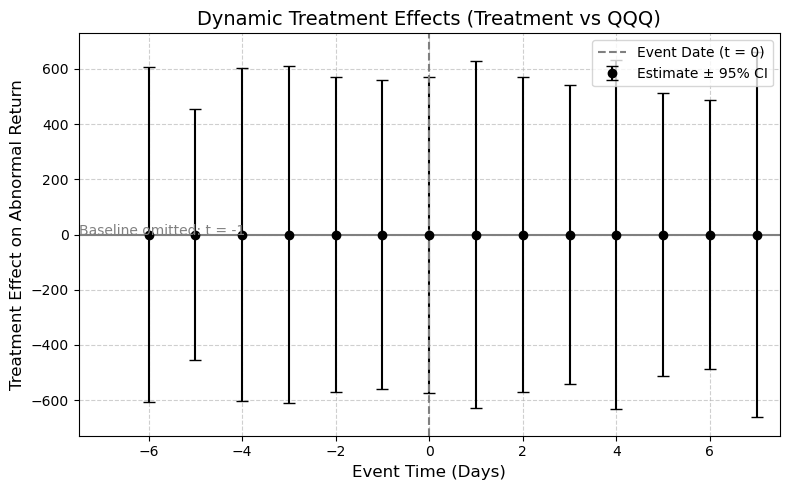

In [728]:
import matplotlib.pyplot as plt

yerr_lower = (treat_effect['coef'] - treat_effect['lower']).abs()
yerr_upper = (treat_effect['upper'] - treat_effect['coef']).abs()

# Plot dynamic treatment effects
plt.figure(figsize=(8, 5))
plt.errorbar(
    treat_effect['event_time'],
    treat_effect['coef'],
    yerr=[yerr_lower, yerr_upper],
    fmt='o', capsize=4, color='black', label='Estimate ± 95% CI'
)

plt.axhline(0, color='gray', linestyle='-')
plt.axvline(0, color='gray', linestyle='--', label='Event Date (t = 0)')
plt.xlim(-7.5, 7.5)
plt.title('Dynamic Treatment Effects (Treatment vs QQQ)', fontsize=14)
plt.xlabel('Event Time (Days)', fontsize=12)
plt.ylabel('Treatment Effect on Abnormal Return', fontsize=12)
plt.legend()
plt.text(-7.5, 0.02, 'Baseline omitted: t = -1', fontsize=10, color='gray')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
